# Hash-Based Dimensionality Reduction for Online Machine Learning

### Initialization

In [101]:
import matplotlib.pyplot as plt
import mmh3
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [102]:
K_VALS = [2**i for i in range(5, 15)]       # Values for destination dimension
C_VALS = [2, 4]                             # Values for number of hash functions

In [103]:
X, y = fetch_20newsgroups(subset='all', return_X_y=True)

In [104]:
vec = TfidfVectorizer(stop_words='english')

X_bow = vec.fit_transform(X)
feature_names = vec.get_feature_names_out()
N, D = X_bow.shape
print(f'Number of samples: {N}, number of features: {D}, number of classes: {len(np.unique(y))}')
print(f'Average number of non-zero features per sample: {X_bow.nnz / N:.4f}')

Number of samples: 18846, number of features: 173451, number of classes: 20
Average number of non-zero features per sample: 113.6621


### Baseline Model Predictions

In [105]:
def calculate_sparsity(X):
    if isinstance(X, np.ndarray):
        return 1 - np.count_nonzero(X) / X.size
    return 1 - X.nnz / np.prod(X.shape)

def train_and_evaluate_model(X, y, model=None, clf=KNeighborsClassifier()):
    if model:
        X = model.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred), calculate_sparsity(X)

baseline_score, baseline_sparsity = train_and_evaluate_model(X_bow, y)
print(f'Baseline accuracy: {baseline_score:.4f}, baseline sparsity: {baseline_sparsity:.4f}')

Baseline accuracy: 0.8101, baseline sparsity: 0.9993


### Convert Sparse Matrix to Dense Representation

In [106]:
def dense_X(bow, feature_names):
    X = []
    for i in range(bow.shape[0]):
        row_indices = bow[i].indices
        row_values = bow[i].data
        row_vals = [(feature_names[j], row_values[idx]) for idx, j in enumerate(row_indices)]
        X.append(row_vals)
    return X

X_dense_bow = dense_X(X_bow, feature_names)

### Feature Hashing

In [107]:
fh_scores = []
fh_sparsities = []
for n_features in K_VALS:
    fh = FeatureHasher(n_features=n_features, input_type='pair')
    print(f'Evaluating {n_features} features')
    score, sparsity = train_and_evaluate_model(X_dense_bow, y, model=fh)
    fh_scores.append(score)
    fh_sparsities.append(sparsity)

Evaluating 32 features
Evaluating 64 features
Evaluating 128 features
Evaluating 256 features
Evaluating 512 features
Evaluating 1024 features
Evaluating 2048 features
Evaluating 4096 features
Evaluating 8192 features
Evaluating 16384 features


K         Accuracy  Sparsity  
32        0.2836    0.1152    
64        0.4292    0.2910    
128       0.5613    0.5012    
256       0.6467    0.6894    
512       0.6950    0.8208    
1024      0.7255    0.9023    
2048      0.7509    0.9484    
4096      0.7674    0.9734    
8192      0.7836    0.9864    
16384     0.7958    0.9931    


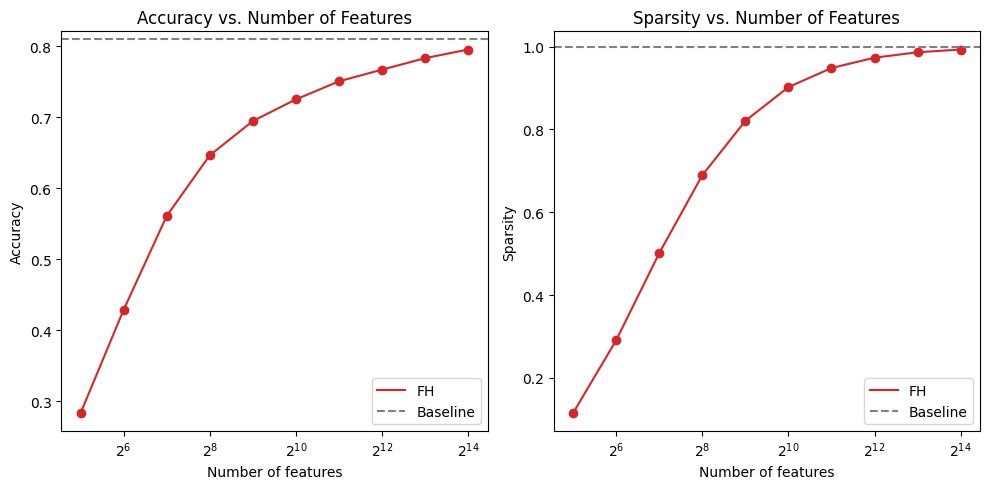

In [108]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot for Accuracy
ax1.set_title('Accuracy vs. Number of Features')
ax1.set_xlabel('Number of features')
ax1.set_ylabel('Accuracy')
ax1.plot(K_VALS, fh_scores, color='tab:red', label='FH')
ax1.scatter(K_VALS, fh_scores, color='tab:red')
ax1.axhline(y=baseline_score, color='gray', linestyle='--', label='Baseline')
ax1.set_xscale('log', base=2)
ax1.legend()

# Plot for Sparsity
ax2.set_title('Sparsity vs. Number of Features')
ax2.set_xlabel('Number of features')
ax2.set_ylabel('Sparsity')
ax2.plot(K_VALS, fh_sparsities, color='tab:red', label='FH')
ax2.scatter(K_VALS, fh_sparsities, color='tab:red')
ax2.axhline(y=baseline_sparsity, color='gray', linestyle='--', label='Baseline')
ax2.set_xscale('log', base=2)
ax2.legend()

print(f"{'K':<10}{'Accuracy':<10}{'Sparsity':<10}")
for i, k in enumerate(K_VALS):
    print(f"{k:<10}{fh_scores[i]:<10.4f}{fh_sparsities[i]:<10.4f}")
    
plt.tight_layout()
plt.show()

### Multi Feature Hashing

In [109]:
class MultiFeatureHasher(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names, n_features, n_hashes=2, seed=0):
        self.feature_names = list(feature_names)
        self.feature_to_index = {f: i for i, f in enumerate(self.feature_names)}
        self.n_features = n_features
        self.n_hashes = n_hashes
        self.signs = self._hash_signs(seed)
        self.hashes = np.array([self._hash_features(seed + i) for i in range(n_hashes)], dtype=np.int64)

    def _hash_signs(self, seed):
        np.random.seed(seed)
        return np.array(np.random.choice([-1, 1], size=len(self.feature_names)), dtype=np.int64)
    
    def _hash_features(self, seed):
        return np.array([mmh3.hash(f.encode('utf-8'), seed, signed=False) for f in self.feature_names], dtype=np.int64)
    
    def transform(self, X, y=None):
        X_hashed = np.zeros((len(X), self.n_features))
    
        for i, row in enumerate(X):
            row_features, row_values = zip(*row)
            feature_indices = [self.feature_to_index[f] for f in row_features]
            
            hs = self.hashes[:, feature_indices] % self.n_features
            v = np.array(row_values) * self.signs[feature_indices] / self.n_hashes**0.5
            
            for h in hs:
                np.add.at(X_hashed[i], h, v)

        return X_hashed
    
    def fit_transform(self, X, y=None):
        return self.transform(X, y)

In [ ]:
mfh_scores = []
mfh_sparsities = []
for n_hashes in C_VALS:
    scores = []
    sparsities = []
    for n_features in K_VALS:
        mfh = MultiFeatureHasher(feature_names, n_features, n_hashes)
        print(f'Evaluating {n_features} features with {n_hashes} hashes')
        score, sparsity = train_and_evaluate_model(X_dense_bow, y, model=mfh)
        scores.append(score)
        sparsities.append(sparsity)
    mfh_scores.append(scores)
    mfh_sparsities.append(sparsities)

Evaluating 32 features with 2 hashes
Evaluating 64 features with 2 hashes
Evaluating 128 features with 2 hashes
Evaluating 256 features with 2 hashes
Evaluating 512 features with 2 hashes
Evaluating 1024 features with 2 hashes
Evaluating 2048 features with 2 hashes
Evaluating 4096 features with 2 hashes
Evaluating 8192 features with 2 hashes


Accuracy:
K         FH        MFH2      MFH4      
64        0.4292    0.4637    0.4658    
128       0.5613    0.6088    0.6170    
256       0.6467    0.6979    0.7194    
512       0.6950    0.7562    0.7711    
1024      0.7255    0.7814    0.7984    
Sparsity:
K         FH        MFH2      MFH4      
64        0.2910    0.1188    0.0276    
128       0.5012    0.2903    0.1144    
256       0.6894    0.5016    0.2876    
512       0.8208    0.6891    0.5021    
1024      0.9023    0.8212    0.6891    


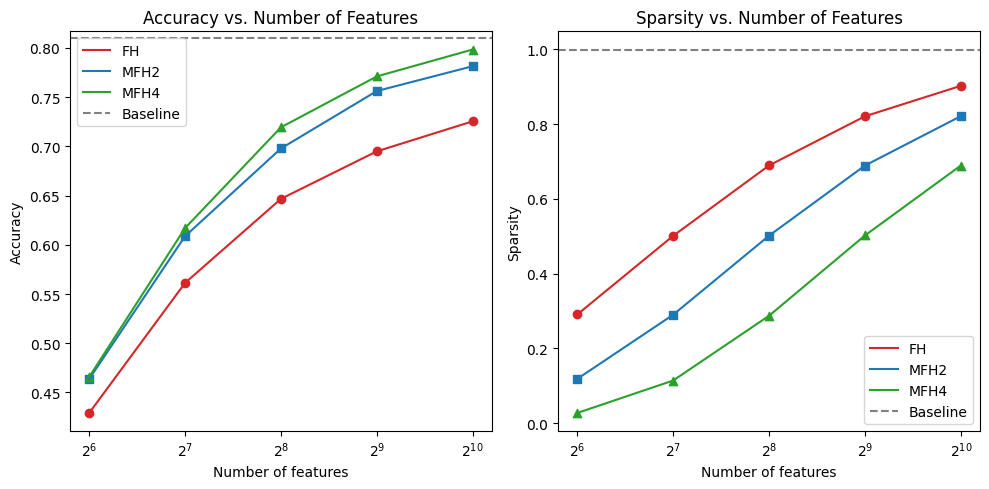

In [ ]:
markers = ['o', 's', '^', 'D', 'x', '*', 'P']
colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:yellow', 'tab:brown']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot for Accuracy
ax1.set_title('Accuracy vs. Number of Features')
ax1.set_xlabel('Number of features')
ax1.set_ylabel('Accuracy')
ax1.plot(K_VALS, fh_scores, label='FH', color=colors[0])
ax1.scatter(K_VALS, fh_scores, color=colors[0], marker=markers[0])
for i, n_hashes in enumerate(C_VALS):
    ax1.plot(K_VALS, mfh_scores[i], label=f'MFH{n_hashes}', color=colors[i+1])
    ax1.scatter(K_VALS, mfh_scores[i], color=colors[i+1], marker=markers[i+1])
ax1.axhline(y=baseline_score, color='gray', linestyle='--', label='Baseline')
ax1.set_xscale('log', base=2)
ax1.legend()

# Plot for Sparsity
ax2.set_title('Sparsity vs. Number of Features')
ax2.set_xlabel('Number of features')
ax2.set_ylabel('Sparsity')
ax2.plot(K_VALS, fh_sparsities, label='FH', color=colors[0])
ax2.scatter(K_VALS, fh_sparsities, color=colors[0], marker=markers[0])
for i, n_hashes in enumerate(C_VALS):
    ax2.plot(K_VALS, mfh_sparsities[i], label=f'MFH{n_hashes}', color=colors[i+1])
    ax2.scatter(K_VALS, mfh_sparsities[i], color=colors[i+1], marker=markers[i+1])
ax2.axhline(y=baseline_sparsity, color='gray', linestyle='--', label='Baseline')
ax2.set_xscale('log', base=2)
ax2.legend()

print("Accuracy:")
print(f"{'K':<10}{'FH':<10}{'MFH2':<10}{'MFH4':<10}")
for i, k in enumerate(K_VALS):
    print(f"{k:<10}{fh_scores[i]:<10.4f}{mfh_scores[0][i]:<10.4f}{mfh_scores[1][i]:<10.4f}")

print("Sparsity:")
print(f"{'K':<10}{'FH':<10}{'MFH2':<10}{'MFH4':<10}")
for i, k in enumerate(K_VALS):
    print(f"{k:<10}{fh_sparsities[i]:<10.4f}{mfh_sparsities[0][i]:<10.4f}{mfh_sparsities[1][i]:<10.4f}")

plt.tight_layout()
plt.show()

### Locality Sensitive Hashing

In [ ]:
class RandomProjectionLSH(BaseEstimator, TransformerMixin):
    def __init__(self, n_features, seed=0):
        self.n_features = n_features
        self.seed = seed
        self.hyperplane = None
        
    def fit(self, X, y=None):
        input_dim = X.shape[1]
        np.random.seed(self.seed)
        self.hyperplane = np.random.randn(input_dim, self.n_features)
        self.hyperplane /= np.linalg.norm(self.hyperplane, axis=0)
        return self
            
    def transform(self, X, y=None):
        X_hashed = X @ self.hyperplane
        return (X_hashed > 0).astype(np.int8)        
    
    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

In [ ]:
lsh_scores = []
lsh_sparsities = []
for n_features in K_VALS:
    lsh = RandomProjectionLSH(n_features)
    print(f'Evaluating {n_features} features')
    score, sparsity = train_and_evaluate_model(X_bow, y, model=lsh)
    lsh_scores.append(score)
    lsh_sparsities.append(sparsity)

Evaluating 64 features
Evaluating 128 features
Evaluating 256 features
Evaluating 512 features
Evaluating 1024 features


Accuracy:
K         FH        MFH2      MFH4      LSH       
64        0.4292    0.4637    0.4658    0.2785    
128       0.5613    0.6088    0.6170    0.4820    
256       0.6467    0.6979    0.7194    0.6454    
512       0.6950    0.7562    0.7711    0.7329    
1024      0.7255    0.7814    0.7984    0.7761    
Sparsity:
K         FH        MFH2      MFH4      LSH       
64        0.2910    0.1188    0.0276    0.4957    
128       0.5012    0.2903    0.1144    0.5017    
256       0.6894    0.5016    0.2876    0.4994    
512       0.8208    0.6891    0.5021    0.4997    
1024      0.9023    0.8212    0.6891    0.5013    


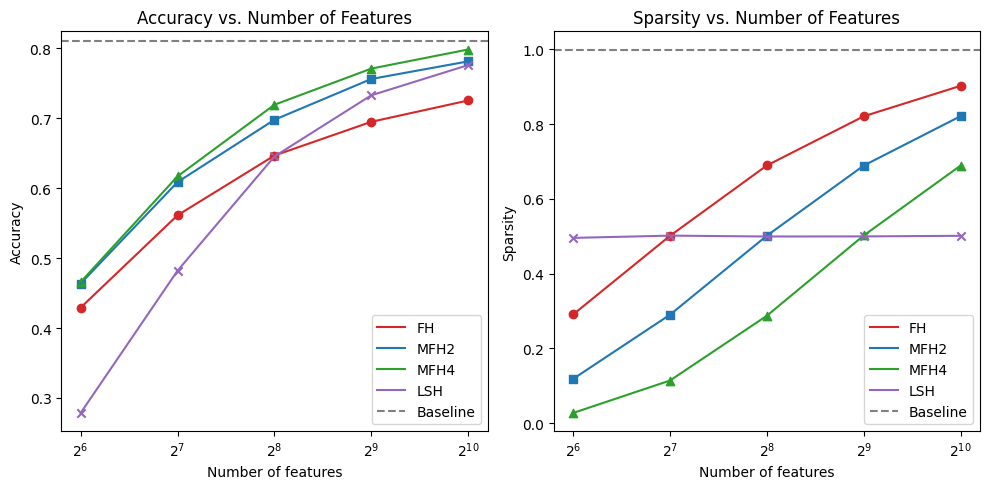

In [ ]:
markers = ['o', 's', '^', 'D', 'x', '*', 'P']
colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:pink', 'tab:brown']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot for Accuracy
ax1.set_title('Accuracy vs. Number of Features')
ax1.set_xlabel('Number of features')
ax1.set_ylabel('Accuracy')
ax1.plot(K_VALS, fh_scores, label='FH', color=colors[0])
ax1.scatter(K_VALS, fh_scores, color=colors[0], marker=markers[0])
for i, n_hashes in enumerate(C_VALS):
    ax1.plot(K_VALS, mfh_scores[i], label=f'MFH{n_hashes}', color=colors[i+1])
    ax1.scatter(K_VALS, mfh_scores[i], color=colors[i+1], marker=markers[i+1])
ax1.plot(K_VALS, lsh_scores, label='LSH', color=colors[2+len(C_VALS)])
ax1.scatter(K_VALS, lsh_scores, color=colors[2+len(C_VALS)], marker=markers[2+len(C_VALS)])
ax1.axhline(y=baseline_score, color='gray', linestyle='--', label='Baseline')
ax1.set_xscale('log', base=2)
ax1.legend()

# Plot for Sparsity
ax2.set_title('Sparsity vs. Number of Features')
ax2.set_xlabel('Number of features')
ax2.set_ylabel('Sparsity')
ax2.plot(K_VALS, fh_sparsities, label='FH', color=colors[0])
ax2.scatter(K_VALS, fh_sparsities, color=colors[0], marker=markers[0])
for i, n_hashes in enumerate(C_VALS):
    ax2.plot(K_VALS, mfh_sparsities[i], label=f'MFH{n_hashes}', color=colors[i+1])
    ax2.scatter(K_VALS, mfh_sparsities[i], color=colors[i+1], marker=markers[i+1])
ax2.plot(K_VALS, lsh_sparsities, label='LSH', color=colors[2+len(C_VALS)])
ax2.scatter(K_VALS, lsh_sparsities, color=colors[2+len(C_VALS)], marker=markers[2+len(C_VALS)])
ax2.axhline(y=baseline_sparsity, color='gray', linestyle='--', label='Baseline')
ax2.set_xscale('log', base=2)
ax2.legend()

print("Accuracy:")
print(f"{'K':<10}{'FH':<10}{'MFH2':<10}{'MFH4':<10}{'LSH':<10}")
for i, k in enumerate(K_VALS):
    print(f"{k:<10}{fh_scores[i]:<10.4f}{mfh_scores[0][i]:<10.4f}{mfh_scores[1][i]:<10.4f}{lsh_scores[i]:<10.4f}")
    
print("Sparsity:")
print(f"{'K':<10}{'FH':<10}{'MFH2':<10}{'MFH4':<10}{'LSH':<10}")
for i, k in enumerate(K_VALS):
    print(f"{k:<10}{fh_sparsities[i]:<10.4f}{mfh_sparsities[0][i]:<10.4f}{mfh_sparsities[1][i]:<10.4f}{lsh_sparsities[i]:<10.4f}")
    
plt.tight_layout()
plt.show()